In [1]:
import numpy as np
import json
import gzip
import random
import matplotlib.pyplot as plt
from collections import defaultdict
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, f1_score, confusion_matrix
from scipy.sparse import hstack

In [2]:
def parse(path):
  with gzip.open(path, 'rt') as g:
      for l in g:
          yield json.loads(l)

# load reviews and sample 200k
sampleSize = 200000
reviews = []
random.seed(42) # for reproducibility

for i, r in enumerate(parse("review-California_10.json.gz")):
    # Ensure text is not None
    if not r.get('text'):
        r['text'] = ""

    # convert timestamps to datetime so that we can train/test split later
    r['time'] = datetime.fromtimestamp(r['time'] / 1000)

    if len(reviews) < sampleSize: 
        reviews.append(r)
    else:
        j = random.randint(0, i)
        if j < sampleSize:
            reviews[j] = r

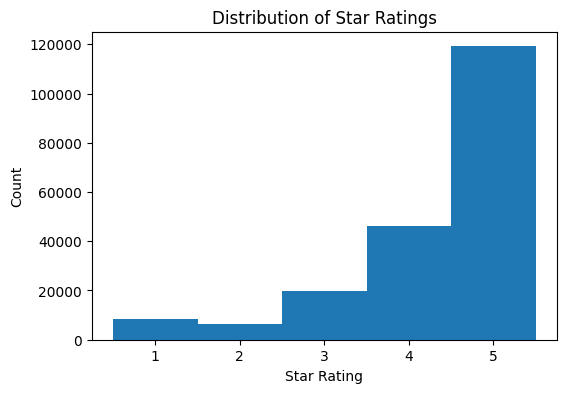

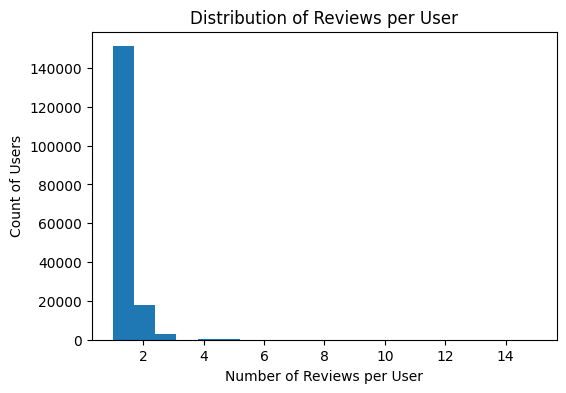

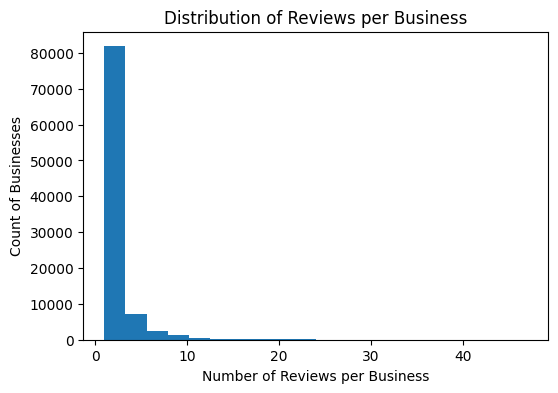

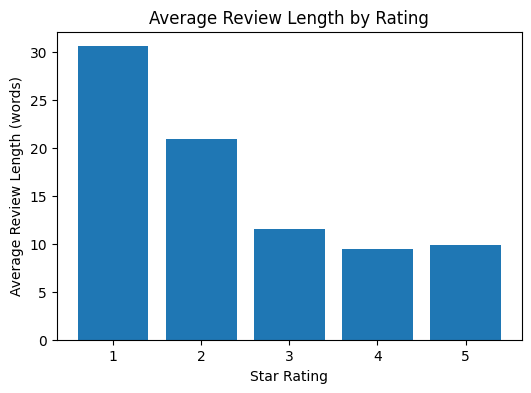

In [3]:
# distribution of star ratings
ratings = [r['rating'] for r in reviews]
plt.figure(figsize=(6,4))
plt.hist(ratings, bins=np.arange(1,7)-0.5)
plt.xlabel("Star Rating")
plt.ylabel("Count")
plt.title("Distribution of Star Ratings")
plt.xticks([1,2,3,4,5])
plt.show()

# distribution of reviews per user
userCounts = defaultdict(int)
for r in reviews:
    userCounts[r['user_id']] += 1
plt.figure(figsize=(6,4))
plt.hist(list(userCounts.values()), bins=20)
plt.xlabel("Number of Reviews per User")
plt.ylabel("Count of Users")
plt.title("Distribution of Reviews per User")
plt.show()

# distribution of reviews per business
businessCounts = defaultdict(int)
for r in reviews:
    businessCounts[r['gmap_id']] += 1
plt.figure(figsize=(6,4))
plt.hist(list(businessCounts.values()), bins=20)
plt.xlabel("Number of Reviews per Business")
plt.ylabel("Count of Businesses")
plt.title("Distribution of Reviews per Business")
plt.show()

# Text statistics by rating
textLengthByRating = defaultdict(list)
for r in reviews:
    textLengthByRating[r['rating']].append(len(r['text'].split()))
avgLengths = [np.mean(textLengthByRating[r]) for r in [1,2,3,4,5]]
plt.figure(figsize=(6,4))
plt.bar([1,2,3,4,5], avgLengths)
plt.xlabel("Star Rating")
plt.ylabel("Average Review Length (words)")
plt.title("Average Review Length by Rating")
plt.xticks([1,2,3,4,5])
plt.show()

In [4]:
# sort reviews by timestamp to train on old and test on new
sortedReviews = sorted(reviews, key=lambda r: r['time'])
splitIndex = int(0.9 * len(sortedReviews))
trainReviews = sortedReviews[:splitIndex]
testReviews = sortedReviews[splitIndex:]

# Extract rating and text
y_train = [r['rating'] for r in trainReviews]
y_test = [r['rating'] for r in testReviews]

trainTexts = [r['text'] if r['text'] else '' for r in trainReviews]
testTexts = [r['text'] if r['text'] else '' for r in testReviews]

In [5]:
# global mean baseline
modeRating = 5 
modePreds = [modeRating] * len(y_test)

# business + user historical average rating
businessSum = defaultdict(int)
businessCount = defaultdict(int)
userSum = defaultdict(int)
userCount = defaultdict(int)

for r in trainReviews:
    businessSum[r['gmap_id']] += r['rating']
    businessCount[r['gmap_id']] += 1
    
    userSum[r['user_id']] += r['rating']
    userCount[r['user_id']] += 1

businessAvg = {b: businessSum[b] / businessCount[b] for b in businessSum}
userAvg = {u: userSum[u] / userCount[u] for u in userSum}

businessPreds = [businessAvg.get(r['gmap_id'], modeRating) for r in testReviews]
roundedBusinessPred = [int(round(p)) for p in businessPreds]

userPreds = [userAvg.get(r['user_id'], modeRating) for r in testReviews]
roundedUserPred = [int(round(p)) for p in userPreds]

# TF-IDF + Logistic Regression baseline
vectors = TfidfVectorizer(max_features=5000, lowercase=True, sublinear_tf=True)
xTrainVec = vectors.fit_transform(trainTexts)
xTestVec = vectors.transform(testTexts)

lr = LogisticRegression(max_iter=5000)
lr.fit(xTrainVec, y_train)
y_pred_lr = lr.predict(xTestVec)

In [6]:
def evaluate(y_true, y_pred, name="Model"):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    mae = mean_absolute_error(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    print(f"--- {name} ---")
    print("Accuracy:", acc)
    print("Weighted F1:", f1)
    print("Mean Absolute Error:", mae)
    print("Confusion Matrix:\n", cm)
    print("\n")

evaluate(y_test, modePreds, "Global Mode Baseline")
evaluate(y_test, roundedBusinessPred, "Business Average Baseline")
evaluate(y_test, roundedUserPred, "User Average Baseline")
evaluate(y_test, y_pred_lr, "TF-IDF + Logistic Regression")

--- Global Mode Baseline ---
Accuracy: 0.65955
Weighted F1: 0.5242459733060167
Mean Absolute Error: 0.6135
Confusion Matrix:
 [[    0     0     0     0   929]
 [    0     0     0     0   576]
 [    0     0     0     0  1522]
 [    0     0     0     0  3782]
 [    0     0     0     0 13191]]


--- Business Average Baseline ---
Accuracy: 0.5095
Weighted F1: 0.5057388397153442
Mean Absolute Error: 0.75625
Confusion Matrix:
 [[  18   29   61  257  564]
 [   5   16   50  183  322]
 [  22   36  118  482  864]
 [  36   62  223 1217 2244]
 [  89  179  576 3526 8821]]


--- User Average Baseline ---
Accuracy: 0.6436
Weighted F1: 0.5476798817775955
Mean Absolute Error: 0.63235
Confusion Matrix:
 [[   13    12    15    25   864]
 [    5     6    18    27   520]
 [    5    13    41    92  1371]
 [    9    26    77   295  3375]
 [   50    41   143   440 12517]]


--- TF-IDF + Logistic Regression ---
Accuracy: 0.6865
Weighted F1: 0.6102271002286911
Mean Absolute Error: 0.4823
Confusion Matrix:
 [[  

In [7]:
reviewsPerUser = defaultdict(list)
reviewsPerItem = defaultdict(list)

for r in trainReviews:
    reviewsPerUser[r['user_id']].append(r)
    reviewsPerItem[r['gmap_id']].append(r)

# improved logistic regression model with full features
improvedVectors = TfidfVectorizer(
    max_features=5000, 
    lowercase=True, 
    sublinear_tf=True,
    ngram_range=(1, 2), 
    min_df=5
)
xTrainVec = improvedVectors.fit_transform(trainTexts)
xTestVec = improvedVectors.transform(testTexts)

# text features (feature engineering)
def extractTextFeatures(reviewList):
    features = []
    for r in reviewList:
        text = r['text']
        features.append([
            len(text.split()),  # checks review length
            text.count('!'),    # possible excitement
        ])
    return np.array(features)

# user/business features (collaborative filtering)
def extractUserAndBusinessFeatures(reviewList):
    features = []
    for r in reviewList:  
        user = r['user_id'] 
        item = r['gmap_id']  

        # Basic CF features 
        user_avg = userAvg.get(user, modeRating)
        business_avg = businessAvg.get(item, modeRating)
        user_count = userCount.get(user, 0)
        business_count = businessCount.get(item, 0)
        
        # user-based similarity
        similarUserAvg = modeRating  
        if item in reviewsPerItem:
            otherUsersRatings = []  
            for review in reviewsPerItem[item]:
                if review['user_id'] != user: 
                    otherUsersRatings.append(userAvg.get(review['user_id'], modeRating))
            if len(otherUsersRatings) > 0:
                similarUserAvg = np.mean(otherUsersRatings) 

        # item-based similarity
        similarItemAvg = modeRating 
        if user in reviewsPerUser:
            otherItemsRatings = []  
            for review in reviewsPerUser[user]:
                if review['gmap_id'] != item: 
                    otherItemsRatings.append(businessAvg.get(review['gmap_id'], modeRating))
            if len(otherItemsRatings) > 0:
                similarItemAvg = np.mean(otherItemsRatings)  
        
        features.append([
            user_avg,
            business_avg,
            user_count,
            business_count,
            similarUserAvg,
            similarItemAvg
        ])
        
    return np.array(features)

trainTextFeats = extractTextFeatures(trainReviews)
testTextFeats = extractTextFeatures(testReviews)
trainUBFeats = extractUserAndBusinessFeatures(trainReviews)
testUBFeats = extractUserAndBusinessFeatures(testReviews)

# combine features
xTrainFull = hstack([xTrainVec, trainTextFeats, trainUBFeats])
xTestFull = hstack([xTestVec, testTextFeats, testUBFeats])

# train
lr_full = LogisticRegression(max_iter=5000, C=1.0, class_weight='balanced')
lr_full.fit(xTrainFull, y_train)
y_pred_full = lr_full.predict(xTestFull)

evaluate(y_test, y_pred_full, "Full Feature Model (Text + User + Business)")

--- Full Feature Model (Text + User + Business) ---
Accuracy: 0.63045
Weighted F1: 0.5528784293357659
Mean Absolute Error: 0.62545
Confusion Matrix:
 [[   10     8    13   105   793]
 [    1     6    13    84   472]
 [    2     6    31   233  1250]
 [    2    16    45   543  3176]
 [   11    52    79  1030 12019]]




/Users/ajhermosillo/assignment2/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 5000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=5000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Overall Accuracy: 0.6304
Classification Report:
               precision    recall  f1-score   support

           1     0.3846    0.0108    0.0209       929
           2     0.0682    0.0104    0.0181       576
           3     0.1713    0.0204    0.0364      1522
           4     0.2722    0.1436    0.1880      3782
           5     0.6787    0.9112    0.7779     13191

    accuracy                         0.6304     20000
   macro avg     0.3150    0.2193    0.2083     20000
weighted avg     0.5319    0.6304    0.5529     20000



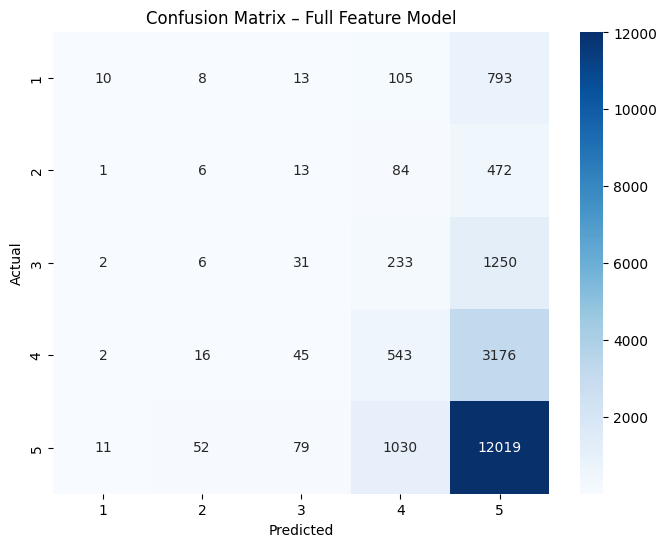


Confusion Matrix Table:


,1,2,3,4,5
1,10,8,13,105,793
2,1,6,13,84,472
3,2,6,31,233,1250
4,2,16,45,543,3176
5,11,52,79,1030,12019


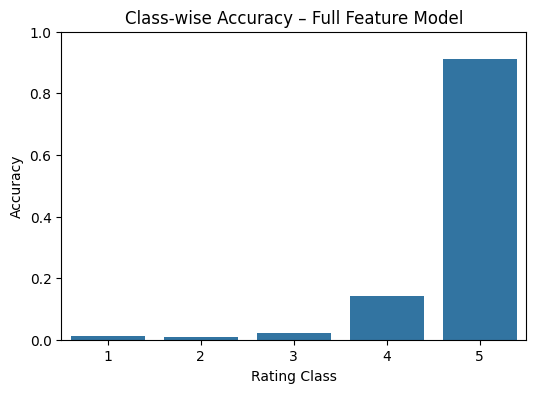

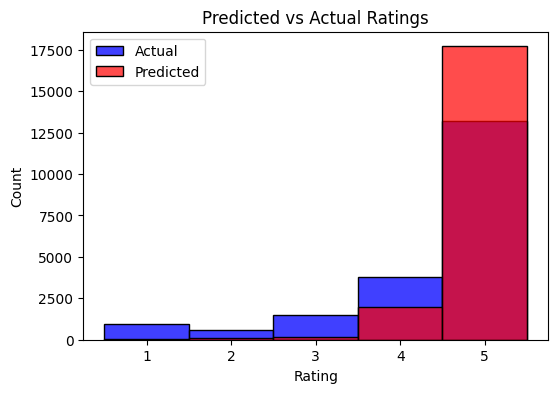

Mean Absolute Error: 0.6254
Weighted F1 Score: 0.5529
Test Set Class Distribution: {np.int64(1): np.int64(929), np.int64(2): np.int64(576), np.int64(3): np.int64(1522), np.int64(4): np.int64(3782), np.int64(5): np.int64(13191)}


,Metric,Value
0,Accuracy,0.630450
1,Weighted F1 Score,0.552878
2,Mean Absolute Error,0.625450


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score

# ------------------------------
# 1. Predictions
# ------------------------------
y_pred_full = lr_full.predict(xTestFull)

# ------------------------------
# 2. Overall Accuracy
# ------------------------------
accuracy = accuracy_score(y_test, y_pred_full)
print(f"Overall Accuracy: {accuracy:.4f}")

# ------------------------------
# 3. Classification Report
# ------------------------------
report = classification_report(y_test, y_pred_full, digits=4)
print("Classification Report:\n", report)

# ------------------------------
# 4. Confusion Matrix
# ------------------------------
cm = confusion_matrix(y_test, y_pred_full)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix – Full Feature Model')
plt.show()

# Optional: pandas DataFrame version
cm_df = pd.DataFrame(cm, index=np.unique(y_test), columns=np.unique(y_test))
print("\nConfusion Matrix Table:")
display(cm_df)

# ------------------------------
# 5. Class-wise Accuracy
# ------------------------------
class_accuracies = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(6,4))
sns.barplot(x=np.unique(y_test), y=class_accuracies)
plt.ylabel("Accuracy")
plt.xlabel("Rating Class")
plt.title("Class-wise Accuracy – Full Feature Model")
plt.ylim(0, 1)
plt.show()

# ------------------------------
# 6. Predicted vs Actual Distribution
# ------------------------------
plt.figure(figsize=(6,4))
sns.histplot(y_test, color='blue', label='Actual', kde=False, discrete=True)
sns.histplot(y_pred_full, color='red', label='Predicted', kde=False, discrete=True, alpha=0.7)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Predicted vs Actual Ratings')
plt.legend()
plt.show()

# ------------------------------
# 7. Mean Absolute Error (optional, since ratings are ordinal)
# ------------------------------
mae = np.mean(np.abs(y_test - y_pred_full))
print(f"Mean Absolute Error: {mae:.4f}")

# ------------------------------
# 8. Weighted F1 Score
# ------------------------------
f1_weighted = f1_score(y_test, y_pred_full, average='weighted')
print(f"Weighted F1 Score: {f1_weighted:.4f}")

# ------------------------------
# 9. Class Distribution (for context)
# ------------------------------
unique, counts = np.unique(y_test, return_counts=True)
class_dist = dict(zip(unique, counts))
print("Test Set Class Distribution:", class_dist)

# ------------------------------
# 10. Summary Table
# ------------------------------
summary = pd.DataFrame({
    'Metric': ['Accuracy', 'Weighted F1 Score', 'Mean Absolute Error'],
    'Value': [accuracy, f1_weighted, mae]
})
display(summary)